## COMP4211 Project Fall 2021
- Name: LAURENT, Michael Jhon
- SID : 20626137
- Email : mjlaurent@connect.ust.hk

In this project, I will be focused on focus  on several machine learning techniques to analyze and detect fraud online credit card transaction. TensorFlow will be the main framework for implementing Neural Network Model.

Dataset taken from : <a href=https://www.kaggle.com/adityakadiwal/credit-card-fraudulent-transactions>• Online Credit Card Transactions from Kaggle</a>


## Neural Network

### 1. Notebook Preparation

#### 1.1 Python Environment

In [1]:
!python3 -V

Python 3.9.6


#### 1.2 Import Library and Depedencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif, chi2

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import torch
from torch.utils.data import Dataset

from tensorflow import keras
from tensorflow.keras import layers

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
seed = 4211

### 2. Data Cleaning and Preprocessing

#### 2.1 FraudDataset Class

In [2]:
class FraudDataset(Dataset):
    # Initialization
    def __init__(self, file_path):
        self.last_element = 16
        self.df = pd.read_csv(file_path)
        self.preprocessing()
        self.skew = {}
        self.drop_skew_data()
    # [] operator
    def __getitem__(self, idx):
        x = np.array(self.df.iloc[idx,:self.last_element]).astype(np.float32)
        y = self.df.iloc[idx,self.last_element]
        return x,y
    # Get the length of data
    def __len__(self):
        return len(self.df)
    # Hyperfunctions 
    def preprocessing(self):
        # Encode LEGIT = 1 and FRAUD = 0
        self.df.drop(['DOMAIN','STATE','ZIPCODE'], axis=1, inplace=True)
        self.df.TRN_TYPE = (self.df.TRN_TYPE == 'FRAUD') * 1
        # Remove Duplicate
        self.df = self.df[~self.df.duplicated()]
        # Remove data with 0 amount
        self.df.drop(self.df[self.df.TRN_AMT == 0].index, inplace=True)
        # Scaled all features
        self.df.iloc[:,:self.last_element] = StandardScaler().fit_transform(self.df.iloc[:,:self.last_element])
    # Get first 10 Data
    def head(self):
        return self.df.iloc[0:10]
    # Count the skewness of data 
    def skew_count(self):
        print("Skewness Score")
        for i in self.df.columns[:16]:
            skewness = self.df[i].skew()
            print(i, ':', skewness)
            self.skew[i] = skewness
    def drop_skew_data(self):
        self.skew_count()
        drop = []
        for i in self.skew:
            if abs(self.skew[i]) > 1:
                drop.append(i)
        print("Dropped column:",drop)
        self.last_element -= len(drop)
        self.df.drop(drop, axis=1, inplace=True)

#### 2.2 Dataset Initialization

In [4]:
file_path = '../CC_FRAUD.csv'
dataset = FraudDataset(file_path)

Skewness Score
TIME1 : -0.4439187528029596
TIME2 : -0.4399144606982198
VIS1 : 2.453257956110042
VIS2 : 7.316127088671902
XRN1 : -0.12122847454808168
XRN2 : -0.17166720027399973
XRN3 : 0.415328796370319
XRN4 : 7.08339064284925
XRN5 : 81.22874321939229
VAR1 : -1.3525854649106335
VAR2 : 0.2818217778093637
VAR3 : -0.8845724422349109
VAR4 : 0.5842556386518353
VAR5 : 2.274885617287391
TRN_AMT : 0.23586925425084848
TOTAL_TRN_AMT : 0.234330135894109
Dropped column: ['VIS1', 'VIS2', 'XRN4', 'XRN5', 'VAR1', 'VAR5']


In [5]:
dataset[0]

(array([-0.3636736 , -0.3663433 , -1.0624485 ,  0.9178447 ,  1.2289947 ,
         1.1507872 ,  0.35571393,  3.0490086 , -0.9922291 , -0.9909143 ],
       dtype=float32),
 0)

#### 2.3 Deep-dive into class label count

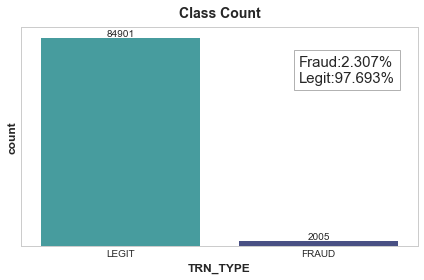

In [6]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
legit = len(dataset.df[dataset.df['TRN_TYPE']==0])/len(dataset.df)
fraud = len(dataset.df[dataset.df['TRN_TYPE']==1])/len(dataset.df)
labels=['LEGIT','FRAUD']
ax = sns.countplot(x='TRN_TYPE', data=dataset.df, palette='mako_r')
ax.bar_label(ax.containers[0])
plt.title('Class Count')
plt.yticks([])
plt.figtext(.7, .7, "Fraud:{:.3f}%\nLegit:{:.3f}%".format(fraud*100,legit*100), bbox ={'facecolor':'white', 
                   'alpha':0.3, 'pad':5}, fontsize=15)
plt.xticks(dataset.df['TRN_TYPE'].value_counts().index, labels)
plt.show()

Notice there is big imbalance on the label distribution, after this, I will demonstrate how class imbalance can severely fail the learning process

#### 3. Model Building

In this part, I will divide model into three parts, 
1. Without Class Balancing
2. Class Balancing using Undersampling Method
3. Class Balancing using Oversampling Method

In [7]:
X = dataset.df.drop('TRN_TYPE',axis=1)
y = dataset.df.TRN_TYPE 

#### 3.1 Without Class Balancing

Data Splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = seed)

y_train.value_counts() # Check for label

0    54337
1     1282
Name: TRN_TYPE, dtype: int64

Model Description

In [9]:
model = keras.Sequential([
    layers.Dense(units= 64, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 32, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 16, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units=1, activation = "sigmoid")
])

metrics = [
    keras.metrics.Precision(name="Precision"),
    keras.metrics.Recall(name="Recall")
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=metrics)


EPOCHS = 200

# Early Stopping for preventing overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1,
    batch_size=32
)

2021-11-27 00:56:11.427302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 00:56:11.495569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200
1739/1739 [==============================] - 3s 1ms/step - loss: 0.1843 - Precision: 0.0114 - Recall: 0.0089 - val_loss: 0.1110 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/200
1739/1739 [==============================] - 1s 862us/step - loss: 0.1272 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 0.1104 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/200
1739/1739 [==============================] - 2s 896us/step - loss: 0.1163 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 0.1114 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/200
1739/1739 [==============================] - 2s 879us/step - loss: 0.1178 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 0.1101 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/200
1739/1739 [==============================] - 2s 919us/step - loss: 0.1154 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 0.1101 - val_Precision: 0.0000e+00 - val_Recall: 0.0000

Model Evaluation

Report

In [10]:
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.round()

print(classification_report(y_test, y_pred, target_names = ['LEGIT','FRAUD']))

              precision    recall  f1-score   support

       LEGIT       0.98      1.00      0.99     16981
       FRAUD       0.00      0.00      0.00       401

    accuracy                           0.98     17382
   macro avg       0.49      0.50      0.49     17382
weighted avg       0.95      0.98      0.97     17382



/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning Plot

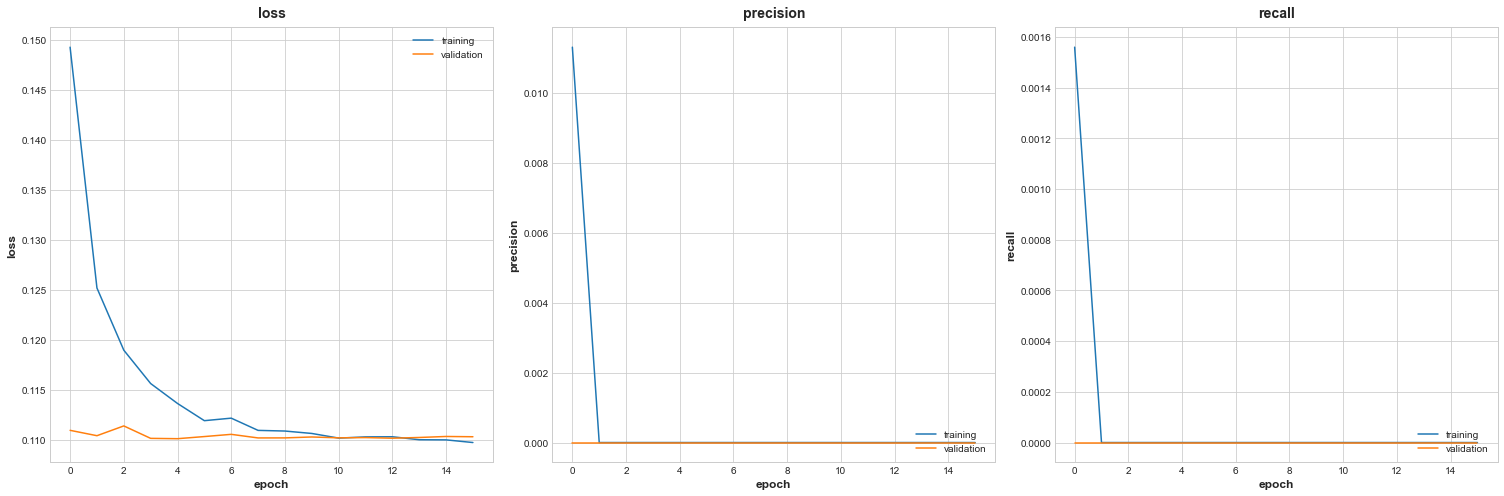

In [11]:
plt.subplots(1,3,figsize=(21,7))
# Loss
plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')


# Precision
plt.subplot(1,3,2)
plt.plot(history.history['Precision'])
plt.plot(history.history['val_Precision'])
plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')

# Recall
plt.subplot(1,3,3)
plt.plot(history.history['Recall'])
plt.plot(history.history['val_Recall'])
plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

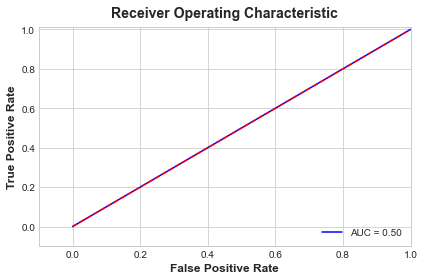

In [12]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 3.2 Class Balancing using Undersampling Method

Class Balancing and Data Splitting

In [13]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=0.2, random_state = seed)

X_train_us, y_train_us = RandomUnderSampler().fit_resample(X_train_us, y_train_us)

y_train_us.value_counts() # Check for balanced label

0    1282
1    1282
Name: TRN_TYPE, dtype: int64

Model Description

In [14]:
model_us = keras.Sequential([
    layers.Dense(units= 64, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 32, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 16, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units=1, activation = "sigmoid")
])

metrics = [
    keras.metrics.Precision(name="Precision"),
    keras.metrics.Recall(name="Recall"),
    
]

model_us.compile(optimizer='adam',loss='binary_crossentropy',metrics=metrics)


EPOCHS = 200

# Early Stopping for preventing overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history_us = model_us.fit(
    X_train_us, y_train_us,
    validation_data=(X_val_us, y_val_us),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1,
    batch_size=32
)

Epoch 1/200
81/81 [==============================] - 1s 6ms/step - loss: 0.7334 - Precision: 0.5412 - Recall: 0.2412 - val_loss: 0.7212 - val_Precision: 0.0244 - val_Recall: 0.7795
Epoch 2/200
81/81 [==============================] - 0s 3ms/step - loss: 0.7066 - Precision: 0.5220 - Recall: 0.5109 - val_loss: 0.7142 - val_Precision: 0.0239 - val_Recall: 0.7950
Epoch 3/200
81/81 [==============================] - 0s 3ms/step - loss: 0.6968 - Precision: 0.5226 - Recall: 0.5551 - val_loss: 0.7224 - val_Precision: 0.0241 - val_Recall: 0.9193
Epoch 4/200
81/81 [==============================] - 0s 3ms/step - loss: 0.6974 - Precision: 0.5191 - Recall: 0.6021 - val_loss: 0.7149 - val_Precision: 0.0240 - val_Recall: 0.9068
Epoch 5/200
81/81 [==============================] - 0s 3ms/step - loss: 0.6960 - Precision: 0.5159 - Recall: 0.6177 - val_loss: 0.7129 - val_Precision: 0.0236 - val_Recall: 0.9161
Epoch 6/200
81/81 [==============================] - 0s 3ms/step - loss: 0.6944 - Precision: 0.

Model Evaluation

Report

In [15]:
y_pred_prob_us = model_us.predict(X_test_us)
y_pred_us = y_pred_prob_us.round()

print(classification_report(y_test_us, y_pred_us, target_names = ['LEGIT','FRAUD']))
print(roc_auc_score(y_test_us,y_pred_us))

              precision    recall  f1-score   support

       LEGIT       0.98      0.15      0.26     16981
       FRAUD       0.02      0.85      0.05       401

    accuracy                           0.17     17382
   macro avg       0.50      0.50      0.15     17382
weighted avg       0.96      0.17      0.26     17382

0.5016842940643209


Learning Plot

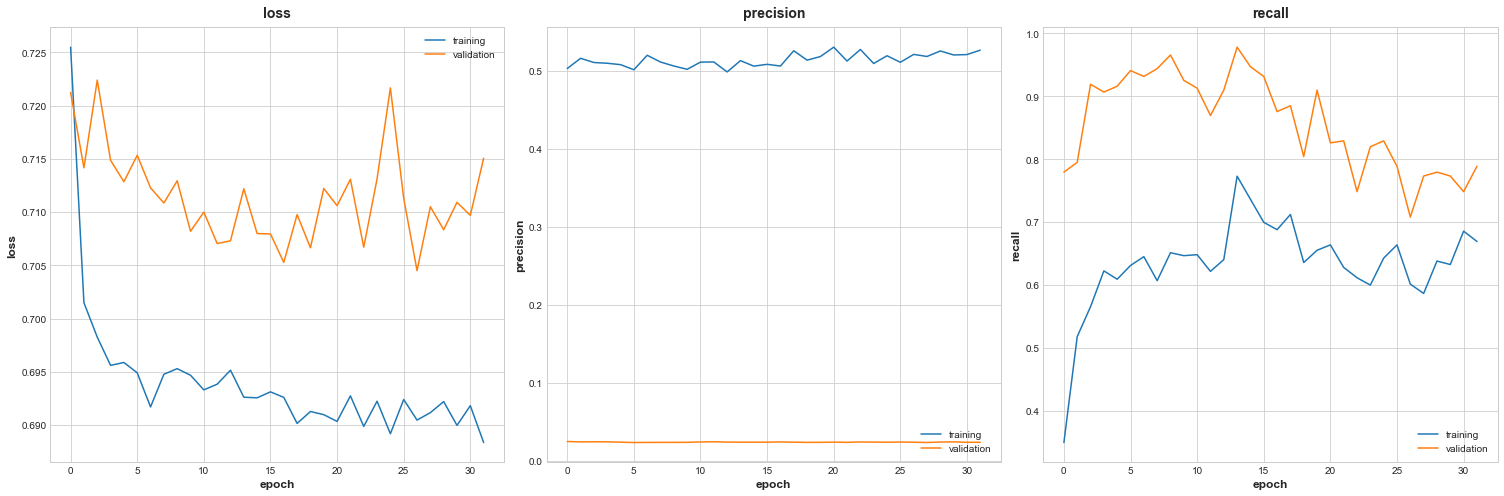

In [16]:
plt.subplots(1,3,figsize=(21,7))

# Loss
plt.subplot(1,3,1)
plt.plot(history_us.history['loss'])
plt.plot(history_us.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')


# Precision
plt.subplot(1,3,2)
plt.plot(history_us.history['Precision'])
plt.plot(history_us.history['val_Precision'])
plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')

# Recall
plt.subplot(1,3,3)
plt.plot(history_us.history['Recall'])
plt.plot(history_us.history['val_Recall'])
plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()


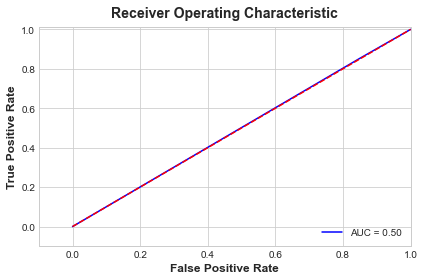

In [17]:
fpr, tpr, threshold = roc_curve(y_test_us, y_pred_us)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 3.3 Class Balancing using Oversampling Method

Class Balancing and Data Splitting

In [18]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os, y_train_os, test_size=0.2, random_state = seed)

smote = SMOTE(random_state=seed)
X_train_os, y_train_os = smote.fit_resample(X_train_os, y_train_os)

y_train_os.value_counts() # Check for label

0    54337
1    54337
Name: TRN_TYPE, dtype: int64

Model Description

In [19]:
model_os = keras.Sequential([
    layers.Dense(units= 64, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 32, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units= 16, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(units=1, activation = "sigmoid")
])

metrics = [
    keras.metrics.Precision(name="Precision"),
    keras.metrics.Recall(name="Recall")
]

model_os.compile(optimizer='adam',loss='binary_crossentropy',metrics=metrics)


EPOCHS = 200

# Early Stopping for preventing overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history_os = model_os.fit(
    X_train_os, y_train_os,
    validation_data=(X_val_os, y_val_os),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1,
    batch_size=32
)


Epoch 1/200
3397/3397 [==============================] - 4s 899us/step - loss: 0.6989 - Precision: 0.5156 - Recall: 0.5709 - val_loss: 0.7119 - val_Precision: 0.0226 - val_Recall: 0.7050
Epoch 2/200
3397/3397 [==============================] - 3s 842us/step - loss: 0.6841 - Precision: 0.5404 - Recall: 0.7215 - val_loss: 0.7106 - val_Precision: 0.0219 - val_Recall: 0.5932
Epoch 3/200
3397/3397 [==============================] - 3s 836us/step - loss: 0.6774 - Precision: 0.5552 - Recall: 0.7052 - val_loss: 0.7050 - val_Precision: 0.0215 - val_Recall: 0.5559
Epoch 4/200
3397/3397 [==============================] - 3s 840us/step - loss: 0.6718 - Precision: 0.5679 - Recall: 0.6915 - val_loss: 0.6989 - val_Precision: 0.0220 - val_Recall: 0.5248
Epoch 5/200
3397/3397 [==============================] - 3s 843us/step - loss: 0.6681 - Precision: 0.5794 - Recall: 0.6824 - val_loss: 0.7317 - val_Precision: 0.0228 - val_Recall: 0.5714
Epoch 6/200
3397/3397 [==============================] - 3s 842us

Model Evaluation

Report

In [20]:
y_pred_prob_os = model_os.predict(X_test_os)
y_pred_os = y_pred_prob_os.round()

print(classification_report(y_test_os, y_pred_os, target_names = ['LEGIT','FRAUD']))
print(roc_auc_score(y_test_os,y_pred_os))

              precision    recall  f1-score   support

       LEGIT       0.98      0.51      0.67     16981
       FRAUD       0.02      0.52      0.05       401

    accuracy                           0.51     17382
   macro avg       0.50      0.51      0.36     17382
weighted avg       0.96      0.51      0.65     17382

0.5149812442570036


Learning Plot

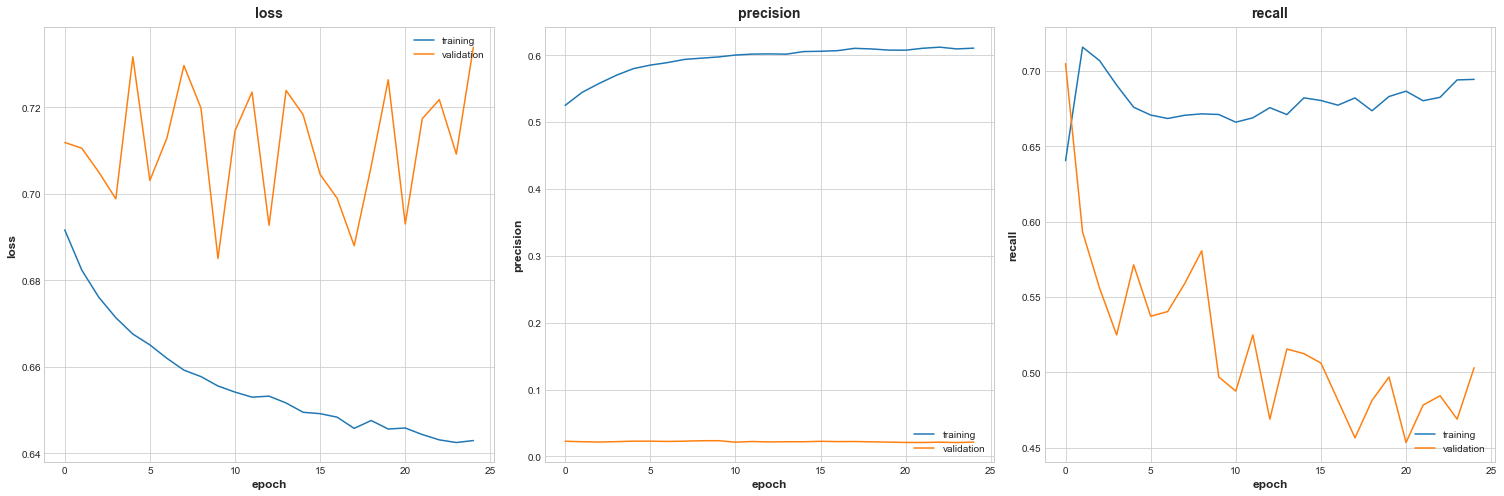

In [21]:
plt.subplots(1,3,figsize=(21,7))

# Loss
plt.subplot(1,3,1,)
plt.plot(history_os.history['loss'])
plt.plot(history_os.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')


# Precision
plt.subplot(1,3,2)
plt.plot(history_os.history['Precision'])
plt.plot(history_os.history['val_Precision'])
plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')

# Recall
plt.subplot(1,3,3)
plt.plot(history_os.history['Recall'])
plt.plot(history_os.history['val_Recall'])
plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

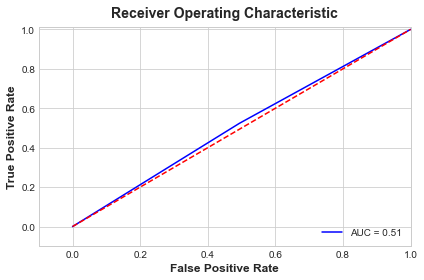

In [22]:
fpr, tpr, threshold = roc_curve(y_test_os, y_pred_os)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### References
1. Credit Fraud || Dealing with Imbalanced Datasets : https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
2. Predicting Fraud with TensorFlow : https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

## Logistic Regression, KNN, SVM, and Decision Tree Classifier

Import Additional Library

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import cross_val_score, GridSearchCV

Model Preparation

Data Import and Augmentation

In [24]:
dataset = FraudDataset(file_path)
X = dataset.df.drop('TRN_TYPE',axis=1)
y = dataset.df.TRN_TYPE 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)


X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
y_train.value_counts()
X_train.shape, X_test.shape, X_val.shape

Skewness Score
TIME1 : -0.4439187528029596
TIME2 : -0.4399144606982198
VIS1 : 2.453257956110042
VIS2 : 7.316127088671902
XRN1 : -0.12122847454808168
XRN2 : -0.17166720027399973
XRN3 : 0.415328796370319
XRN4 : 7.08339064284925
XRN5 : 81.22874321939229
VAR1 : -1.3525854649106335
VAR2 : 0.2818217778093637
VAR3 : -0.8845724422349109
VAR4 : 0.5842556386518353
VAR5 : 2.274885617287391
TRN_AMT : 0.23586925425084848
TOTAL_TRN_AMT : 0.234330135894109
Dropped column: ['VIS1', 'VIS2', 'XRN4', 'XRN5', 'VAR1', 'VAR5']


((2566, 10), (17382, 10), (13905, 10))

Grid Search for Hyperparameter Tuning

In [25]:
# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1], "max_iter": [200]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Tree Best estimator
tree_clf = grid_tree.best_estimator_

Model Evaluation

Report

In [38]:
from sklearn.metrics import confusion_matrix
print("Logistic Regression Classifier")
log_y_pred = log_reg.predict(X_test)
print(classification_report(y_test, log_y_pred, target_names = ['LEGIT','FRAUD']))
print("ROC Score: ", roc_auc_score(y_test,log_y_pred))

print("KNN Classifier")
nears_neighbors_y_pred = knears_neighbors.predict(X_test)
print(classification_report(y_test, nears_neighbors_y_pred, target_names = ['LEGIT','FRAUD']))
print("ROC Score: ", roc_auc_score(y_test,nears_neighbors_y_pred))

print("Support Vector Classifier")
svc_y_pred = svc.predict(X_test)
print(classification_report(y_test, svc_y_pred, target_names = ['LEGIT','FRAUD']))
print("ROC Score: ", roc_auc_score(y_test,svc_y_pred))

print("Decision Tree Classifier")
tree_clf_y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, tree_clf_y_pred, target_names = ['LEGIT','FRAUD']))
print("ROC Score: ", roc_auc_score(y_test,tree_clf_y_pred))


Logistic Regression Classifier
              precision    recall  f1-score   support

       LEGIT       0.98      0.50      0.66     16981
       FRAUD       0.03      0.56      0.05       401

    accuracy                           0.50     17382
   macro avg       0.50      0.53      0.36     17382
weighted avg       0.96      0.50      0.65     17382

ROC Score:  0.5307400188064084
KNN Classifier
              precision    recall  f1-score   support

       LEGIT       0.98      0.68      0.80     16981
       FRAUD       0.02      0.32      0.04       401

    accuracy                           0.67     17382
   macro avg       0.50      0.50      0.42     17382
weighted avg       0.95      0.67      0.78     17382

ROC Score:  0.4987153017286006
Support Vector Classifier
              precision    recall  f1-score   support

       LEGIT       0.98      0.47      0.64     16981
       FRAUD       0.03      0.59      0.05       401

    accuracy                           0.48     

ROC Curve

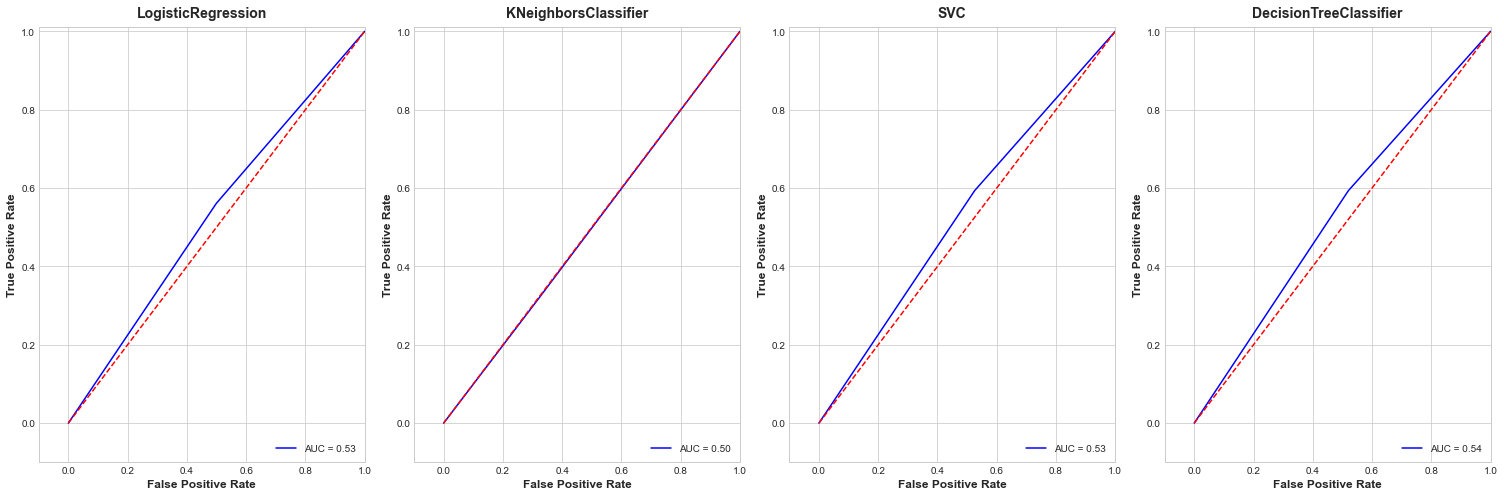

In [37]:
plt.subplots(1,4,figsize=(21,7))
# plt.subtitle('Receiver Operating Characteristic')
def plot_roc(label, idx, y_test, y_pred):
    plt.subplot(1,4,idx)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.gca().set_title(str(label))
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

name = ['LogisticRegression','KNeighborsClassifier','SVC','DecisionTreeClassifier']
pred = [log_y_pred, nears_neighbors_y_pred, svc_y_pred, tree_clf_y_pred]
for i in range(1,5):
    plot_roc(name[i-1], i, y_test, pred[i-1])
plt.show()


## Remarks

In [3]:
df = pd.read_csv('../CC_FRAUD.csv')

In [4]:
df

,DOMAIN,STATE,ZIPCODE,TIME1,TIME2,VIS1,VIS2,XRN1,XRN2,XRN3,XRN4,XRN5,VAR1,VAR2,VAR3,VAR4,VAR5,TRN_AMT,TOTAL_TRN_AMT,TRN_TYPE
0,CDRZLKAJIJVQHCN.COM,AO,675,12,12,1,0,0,1,1,0,1,2,1,16.680,34,0,12.95,12.95,LEGIT
1,NEKSXUK.NET,KK,680,18,18,1,0,0,0,0,0,1,3,0,37.880,23,0,38.85,38.85,LEGIT
2,XOSOP.COM,UO,432,3,3,1,0,0,1,1,0,1,3,1,-9.080,19,2,38.85,38.85,LEGIT
3,TMA.COM,KR,119,23,23,0,0,1,0,0,0,3,0,0,-6.392,18,0,11.01,11.01,LEGIT
4,VUHZRNB.COM,PO,614,9,9,0,0,0,1,0,0,1,3,0,42.512,7,0,12.95,12.95,LEGIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94677,XOSOP.COM,MO,685,11,11,0,0,0,1,1,0,1,3,0,8.112,15,1,49.95,49.95,LEGIT
94678,RONHGNCN.COM,KR,108,16,16,0,0,1,0,0,1,1,4,0,11.248,10,4,12.95,12.95,LEGIT
94679,XOSOP.COM,VO,601,18,18,0,0,1,1,1,0,1,2,0,27.824,23,0,38.85,38.85,LEGIT
94680,VUHZRNB.COM,LO,398,23,23,0,0,0,0,0,0,1,3,0,31.904,20,0,12.95,12.95,LEGIT


In [6]:
v_features = df.loc[:,'TIME1':'TOTAL_TRN_AMT'].columns


/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/comp4211/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

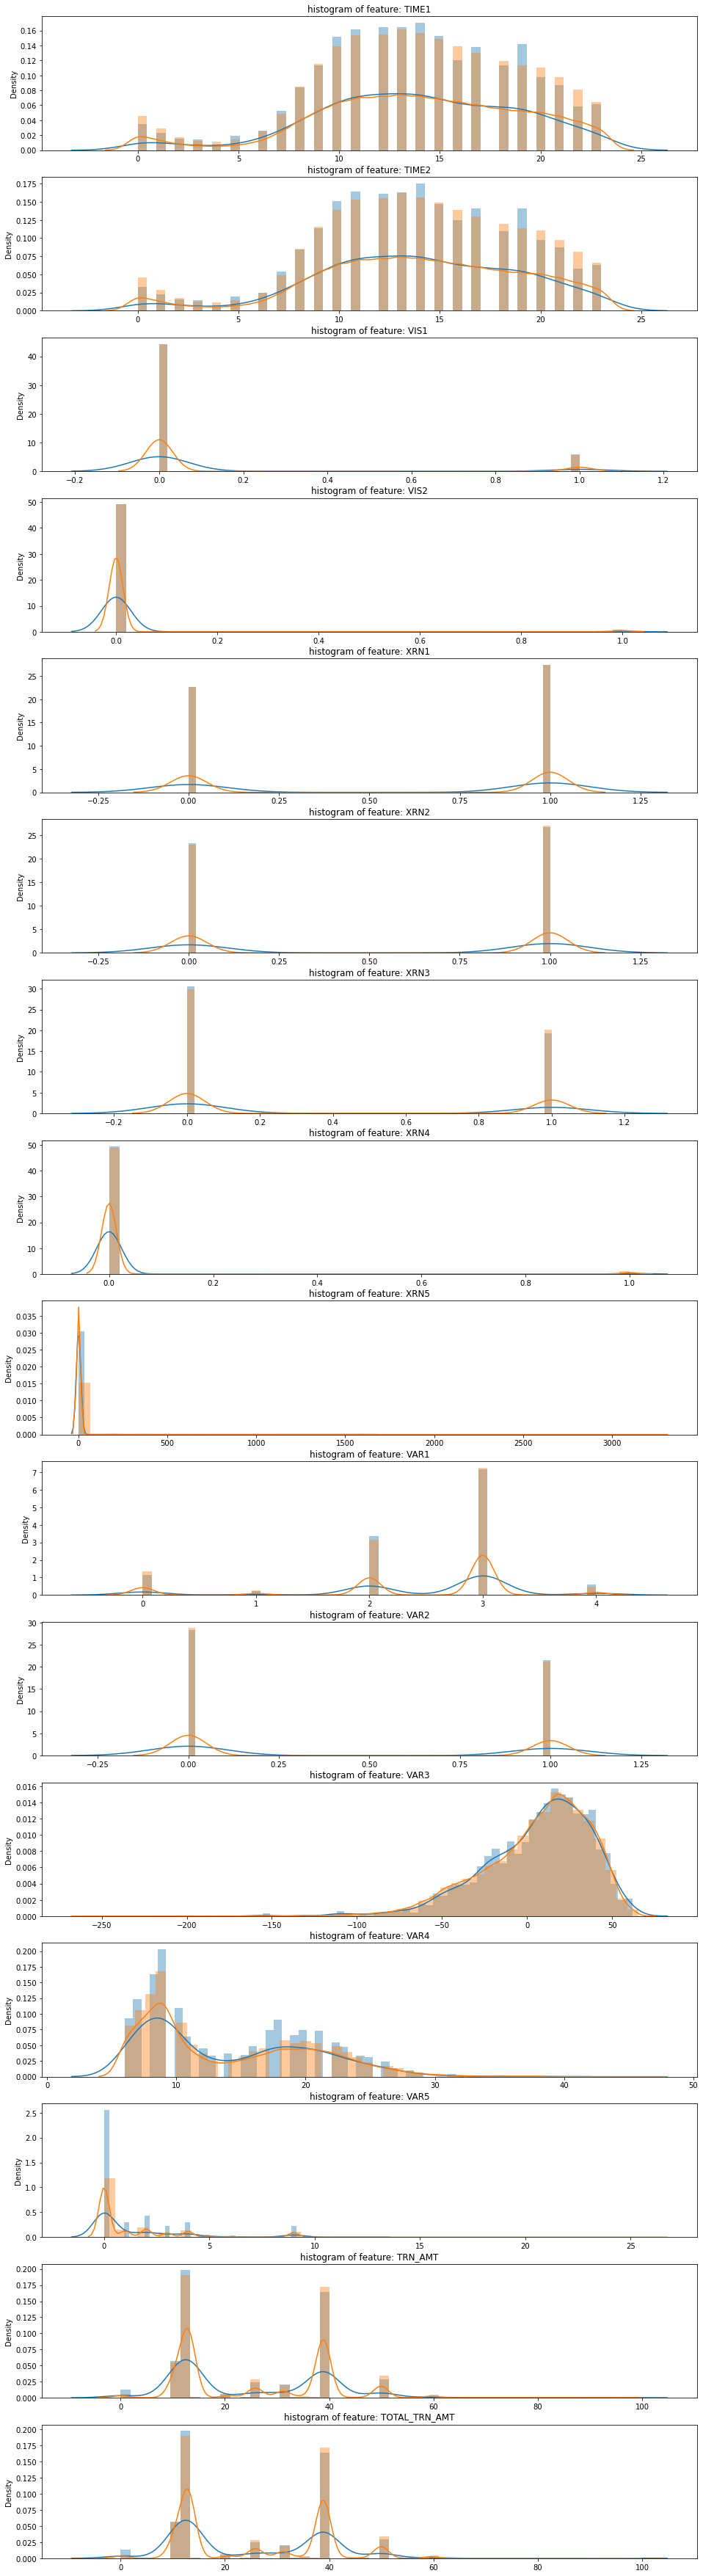

In [11]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(16,28*4))
gs = gridspec.GridSpec(28, 1)

for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.TRN_TYPE == 'FRAUD'], bins=50, label='fraud')
    sns.distplot(df[cn][df.TRN_TYPE == 'LEGIT'], bins=50, label='legit')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()
